Se adicionaron 62 (63 rows) registros de boundaries

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import numpy as np 
import plotly.express as px
import matplotlib.pyplot as plt
# load utils
import utils as ut
import numpy as np
import scipy as sp
import scipy.stats as st
import itertools as it
pd.set_option('display.max.columns', 100)

factorsModel = ['trees', 'depth']


Carga de archivos de los resultados, los resultados estan desagregados, entre drop3 y entropy.

In [2]:
def compute_metrics (row):
    #print(df)
    row['wtdAcc'] = 0.7*row['sensibility'] + 0.3*row['specificity']
    row['balancedAcc'] = (row['sensibility'] + row['specificity'])/2
    mcc_den = (row.tp+row.fp) * (row.tp + row.fn) * (row.tn+row.fp) * (row.tn+row.fn)
    #print(mcc_den)
    row['mcc'] = ((row.tp*row.tn) - (row.fp*row.fn))/ np.sqrt( float(mcc_den) )
    return (row)

In [3]:
# filter out the no instance selection and drop3
# carga de dataframe para entropy
entropy_results_ori = ut.read_results("./data/is_experiments",  ["susyAllResults.csv"])
condition = (entropy_results_ori.isMethod != 'drop3') & (entropy_results_ori.instanceSelection != 'NOIS')
no_is_results =  entropy_results_ori[entropy_results_ori.instanceSelection == 'NOIS'].copy().reset_index(drop= True)
entropy_results = entropy_results_ori[condition].copy().reset_index(drop= True)

entropy_results = entropy_results.apply(compute_metrics , axis = 1)
no_is_results = no_is_results.apply(compute_metrics , axis = 1)

--- 
para adaptar los resultados de rf puro

In [4]:
# resultados de rf
# we need to keep only best parameters
# of trees and depth, for each type (train-test)
rf_p2p = pd.read_csv("data/results_no_is/confusionAll.csv")
rf_p2p['counts'] = rf_p2p.groupby(['tipo',
                'trees',
                'impurity', 
                'depth', 'bins'])['tp'].transform('count')
rf_p2p = rf_p2p[rf_p2p['counts']==5].drop('counts', axis = 1)
rf_p2p['k'] = rf_p2p.groupby([ 'trees', 'depth',  'impurity', 'bins', 'tipo']).cumcount()+1

In [5]:
print("before", rf_p2p[(rf_p2p.trees==100) & ((rf_p2p.depth==20)) ].shape)

rf_p2p = rf_p2p#[rf_p2p.k<=5]
print(rf_p2p.tipo.unique())
rf_p2p = rf_p2p.sort_values(['F1', 'trees', 'depth', 'tipo', 'k'], ascending = False).drop_duplicates(['trees', 'depth', 'tipo','k'])

print("after dedup", rf_p2p[(rf_p2p.trees==100) & ((rf_p2p.depth==20)) ].shape)
print(rf_p2p.tipo.unique())
rf_p2p = rf_p2p.drop(['bins', 'impurity', 'PEXC', 'MCC'], axis =1).reset_index(drop = True)
print(rf_p2p.columns)
rf_p2p.columns = ['type', 'tp', 'fn', 'tn', 'fp', 'sensibility', 'specificity', 'precision', 'accuracy', 'F1', 'Gmean', 'AreaROC', 'trees', 'depth', 'k']
print(rf_p2p.type.unique())
print(rf_p2p[(rf_p2p.trees==100) & ((rf_p2p.depth==20)) ].shape)
rf_p2p_final = rf_p2p.copy().apply(lambda row : compute_metrics(row) , axis = 1)
rf_p2p_final['database'] = 'p2p'
print(rf_p2p_final.type.unique())

before (60, 19)
['test' 'train']
after dedup (10, 19)
['train' 'test']
Index(['tipo', 'tp', 'fn', 'tn', 'fp', 'TPR', 'SPC', 'PPV', 'ACC', 'F1',
       'MGEO', 'areaRoc', 'trees', 'depth', 'k'],
      dtype='object')
['train' 'test']
(10, 15)
['train' 'test']


In [6]:
ignore_cols = [] # ['subBuckets', 'buckAvg', 'reduction', 'buckets', 'buckMax', 'buckMin', 'timeIS', 'timeLSH']
#missing_columns = (set(no_is_results.columns) - set(rf_p2p_final.columns)) - set(ignore_cols)
missing_columns =  ['ands', 'lshMEthod', 'isMethod', 'instanceSelection', 'imbalance', 'ors']
print("missing", missing_columns)
cols_to_complete = no_is_results[missing_columns].copy().drop_duplicates(
    ['lshMEthod', 'ands', 'imbalance', 'isMethod', 'instanceSelection']).reset_index(drop = True)
cols_to_complete['aux'] = 1
rf_p2p_final['aux'] = 1
rf_p2p_final = pd.merge(cols_to_complete, rf_p2p_final, how = 'left', on = 'aux').drop('aux', axis = 1)

missing ['ands', 'lshMEthod', 'isMethod', 'instanceSelection', 'imbalance', 'ors']


In [7]:
rf_p2p_final.groupby(factorsModel)['tp'].count()

trees  depth
2      10       300
       20       300
       30       300
10     10       300
       20       300
       30       300
50     10       300
       20       300
       30       300
100    10       300
       20       300
       30       300
Name: tp, dtype: int64

In [8]:
no_is_results['type'] = no_is_results['type'].str.lower()
no_is_results = pd.concat([no_is_results[rf_p2p_final.columns], rf_p2p_final[rf_p2p_final.columns]], ignore_index=True)


---


Ahora todos los resultados de drop3

In [9]:
# filter out the no instance selection and drop3
# carga de dataframe para entropy
drop3_files = ['boundaries.csv', "one.csv", "test.csv"]
drop3_results = ut.read_results("./data/drop3",  drop3_files)
condition = (drop3_results.isMethod == 'drop3') & (drop3_results.instanceSelection != 'NOIS')
drop3_results = drop3_results[condition].copy().reset_index(drop= True)
# in the drop3 the file have the db and the
# one sample bucket
drop3_results = drop3_results.apply(compute_metrics , axis = 1)
drop3_results[['database', 'one_class_method']] = drop3_results.database.str.replace(".csv", "").str.split("_", expand = True)

Now We will concatenate the results



In [10]:
entropy_results['one_class_method'] = 'entropy'
drop3_entropy = pd.concat([entropy_results, drop3_results], ignore_index=True)
# deduplicate records
drop3_entropy = drop3_entropy.drop_duplicates()

In [11]:
## add axiliary results        
drop3_entropy['Total Time'] = drop3_entropy.timeLSH + drop3_entropy.timeIS
drop3_entropy['total'] = drop3_entropy.tp + drop3_entropy.tn + drop3_entropy.fn + drop3_entropy.fp
drop3_entropy['samples by bucket average (relative)'] = drop3_entropy.buckAvg/drop3_entropy.total*100.0
drop3_entropy['model_complexity'] =  drop3_entropy.trees*drop3_entropy.depth
drop3_entropy['Reduction of DataSet(%)'] = (1 - drop3_entropy['reduction'])*100.0
drop3_entropy['type'] = drop3_entropy['type'].str.lower()

# Adapt the dataframes to plots

In [12]:
cols_to_dedup = ['lshMEthod', 'ands', 'imbalance', 'isMethod', 'database', 'k', 'type', 'instanceSelection'] + factorsModel

In [26]:
measuresNoIS = ['tp', 'tn', 'fp', 'fn', 'sensibility','specificity', 'precision', 
                'accuracy', 'F1', 'Gmean', 'wtdAcc','AreaROC', 'balancedAcc', 'mcc']
factorsNoIS = ['database']
cols_to_dedup_noIs = ['ands', 'database', 'k', 'type'] +factorsModel
no_is_results_dp =  no_is_results.drop_duplicates(cols_to_dedup_noIs)
best_no_is = (no_is_results_dp.groupby(factorsNoIS)
                .apply(lambda g : ut.get_best_for(g, 
                measuresNoIS, 
                measure_sort = 'Gmean', 
                factorsModel = factorsModel, 
                debug = False, 
                agg=False))
                .reset_index())


best_no_is['model_complexity'] =  best_no_is.trees*best_no_is.depth

In [27]:
no_is_results_dp[no_is_results_dp.database=='pageblocks'].k.unique()
no_is_results_dp[no_is_results_dp.database=='fraudk'].k.unique()
no_is_results_dp[no_is_results_dp.database=='p2p'].k.unique()

array([2, 5, 1, 3, 4])

In [28]:
display(best_no_is[best_no_is.database=='pageblocks'].k.unique())
display(best_no_is[best_no_is.database=='fraudk'].k.unique())
display(best_no_is[best_no_is.database=='p2p'].k.unique())

array([1, 2, 3, 4, 5])

array([1, 2, 3, 4, 5])

array([2, 1, 5, 3, 4])

In [29]:
 #best_no_is['k']= best_no_is.groupby(['tp', 'database', 'type', 'trees', 'depth']).cumcount()+1

In [30]:
ands = no_is_results.ands.unique()
dfs = []
for a in ands:
    df_partial = best_no_is.copy()
    df_partial['ands'] = a
    dfs.append(df_partial)
best_no_is = pd.concat(dfs, ignore_index=True)

In [31]:
drop3_entropy.drop_duplicates(cols_to_dedup).groupby(['database', 
                        'instanceSelection',
                        'imbalance', 
                        'lshMEthod']+ factorsModel)['tp'].count()

database     instanceSelection  imbalance  lshMEthod    trees  depth
credit_card  IS                 False      hyperplanes  10     10        50
                                                               20        50
                                                               30        50
                                                        25     10        50
                                                               20        50
                                                                       ... 
pageblocks   IS                 True       projection   25     20       100
                                                               30       100
                                                        50     10       100
                                                               20       100
                                                               30       100
Name: tp, Length: 162, dtype: int64

In [32]:
drop3_entropy[drop3_entropy.imbalance==True].drop_duplicates(cols_to_dedup +[ 'one_class_method']).groupby(['database', 
                        'instanceSelection',
                        'one_class_method',
                        'lshMEthod']).agg({'tp': 'count', 'ands': 'unique', 'k': ['unique'],  'trees': 'unique', 'depth': 'unique'})

tp  \
                                                                              count   
database            instanceSelection one_class_method lshMEthod                      
credit_card         IS                drop3-boundaries hyperplanes              450   
                                                       hyperplanes-projection   450   
                                                       projection               450   
                                      drop3-one        hyperplanes              450   
                                                       hyperplanes-projection   450   
                                                       projection               450   
                                      entropy          hyperplanes              450   
                                                       hyperplanes-projection   450   
                                                       projection               450   
gateway_credit_card IS                drop3-boundaries hyperplanes              257   
                                                       hyperplanes-projection   234   
                                                       projection               216   
                                      drop3-one        hyperplanes              322   
                                                       hyperplanes-projection   300   
                                                       projection               288   
                                      entropy          hyperplanes              450   
                                                       hyperplanes-projection   450   
                                                       projection               450   
pageblocks          IS                drop3-boundaries hyperplanes              450   
                                                       hyperplanes-projection   450   
                                                       projection               450   
                                      drop3-one        hyperplanes              450   
                                                       hyperplanes-projection   450   
                                                       projection               450   
                                      entropy          hyperplanes              450   
                                                       hyperplanes-projection   450   
                                                       projection               450   

                                                                                           ands  \
                                                                                         unique   
database            instanceSelection one_class_method lshMEthod                                  
credit_card         IS                drop3-boundaries hyperplanes             [6, 8, 10, 2, 4]   
                                                       hyperplanes-projection  [6, 8, 10, 2, 4]   
                                                       projection              [6, 8, 10, 2, 4]   
                                      drop3-one        hyperplanes             [2, 4, 6, 8, 10]   
                                                       hyperplanes-projection  [2, 4, 6, 8, 10]   
                                                       projection              [2, 4, 6, 8, 10]   
                                      entropy          hyperplanes             [2, 4, 6, 8, 10]   
                                                       hyperplanes-projection  [2, 4, 6, 8, 10]   
                                                       projection              [2, 4, 6, 8, 10]   
gateway_credit_card IS                drop3-boundaries hyperplanes             [6, 2, 4, 8, 10]   
                                                       hyperplanes-projection  [2, 4, 6, 8, 10]   
                                                       projection              [2, 4

In [33]:
drop3_entropy[drop3_entropy.imbalance==True].drop_duplicates(cols_to_dedup +[ 'one_class_method']).groupby(['database', 
                        'instanceSelection',
                        'one_class_method',
                        'k',
                        'lshMEthod']).agg({'tp': 'count', 'ands': 'unique', 'trees': 'unique', 'depth': 'unique'}).to_excel("check.xlsx")

In [34]:
factorsIS = ['lshMEthod', 'ands', 'imbalance', 'isMethod', 'database', 'one_class_method']

measures = ['tp', 'tn', 'fp', 'fn', 'sensibility','specificity', 'precision', 'accuracy', 'F1', 
'Gmean','wtdAcc', 'balancedAcc', 'mcc','AreaROC', 'timeIS', 'timeLSH', 'model_complexity', 'Total Time', 'Reduction of DataSet(%)']

In [35]:
drop3_entropy.one_class_method.unique()

array(['entropy', 'drop3-boundaries', 'drop3-one'], dtype=object)

In [38]:
drop3_entropy['database'].unique()

array(['credit_card', 'gateway_credit_card', 'pageblocks'], dtype=object)

In [40]:
drop3_entropy.one_class_method.unique()

array(['entropy', 'drop3-boundaries', 'drop3-one'], dtype=object)

In [41]:
## correct some values names
def adjust_names (value, fix):
    return (fix[value])

#drop3_entropy['database']= drop3_entropy.database.apply(adjust_names, fix={'fraudk': 'credit_card', #'p2p':'gateway_credit_card', 'pageblocks': 'pageblocks'})

#drop3_entropy.one_class_method = drop3_entropy.one_class_method.apply(adjust_names, fix={'entropy': #'entropy', 'boundaries':'drop3-boundaries', 'one': 'drop3-one'})

In [43]:
#best_no_is['database']= best_no_is.database.apply(adjust_names, fix={'fraudk': 'credit_card', #'p2p':'gateway_credit_card', 'pageblocks': 'pageblocks'})

## the actual plots

In [44]:
def plot_9_results (df_in, df_reference, measure = 'Gmean', measure_for_best = 'Gmean', aspect=2, height=8):

    linewidth =  5
    col_order = ['credit_card/\nentropy', 'credit_card/\ndrop3-boundaries', 'credit_card/\ndrop3-one',
                'pageblocks/\nentropy', 'pageblocks/\ndrop3-boundaries', 'pageblocks/\ndrop3-one',
                'gateway_credit_card/\nentropy', 'gateway_credit_card/\ndrop3-boundaries', 'gateway_credit_card/\ndrop3-one']
    gg = sns.relplot(data = df_in[df_in.type=='test'], x ='ands', 
                y= measure, 
                style = 'lshMEthod', 
                hue = 'lshMEthod', 
                col = 'db/IS_Method',
                col_wrap=3,
                col_order = col_order,
                kind = 'line', 
                aspect = aspect,
                height=height,
                facet_kws = {'sharey': 'row'},
                linewidth =linewidth,
                err_style =  'bars',  legend = 'full')
    
    leg = gg._legend
    
    g = sns.relplot(data = df_in[df_in.type=='test'], x ='ands', 
                y= measure, 
                style = 'lshMEthod', 
                hue = 'lshMEthod', 
                col = 'db/IS_Method',
                col_wrap=3,
                col_order = col_order,
                kind = 'line', 
                aspect = aspect,
                height=height,
                facet_kws = {'sharey': 'row'},
                linewidth =linewidth-0.8,
                err_style =  'bars',  legend = False)
    
    if df_reference is not None:
        # add reference
        axs  = np.ravel (g.axes)
        for ax in np.ravel(axs):
            db = ut.get_db_from_ax(ax).split("/")[0]
            mea_test = df_reference.loc[(df_reference.database==db) & (df_reference.type == 'test'), ['ands', measure]].copy()
            mea_test['reference'] = 'reference'
            if len(mea_test) > 0:
                xx = sns.lineplot(x="ands", 
                                y=measure, data=mea_test,
                                ax = ax, 
                                palette = ['slategray'], 
                                legend = False, 
                                linewidth =linewidth,
                                style_order= ["-."],
                                err_style =  'bars',
                                hue = 'reference')
        current_labels = [label.get_text() for label in leg.texts] + ['reference']
        current_handlers = leg.legendHandles + [ax.lines[-2]]
        dict_legend = {label: handler for label,handler in zip (current_labels, current_handlers) }
        g.fig.subplots_adjust(wspace=0.1, hspace=0.1, top = 1.0 )
        #(x, y, width, height)
        g.add_legend(dict_legend, bbox_to_anchor=(0.05, 1.1,1.0, 0.0), loc='upper left',
                     ncol=5, mode=None, borderaxespad=0.5, fontsize = 28, borderpad = 0.8)
        for line in g._legend.get_lines():
            line.set_linewidth(linewidth+0.5)    
    #plt.tight_layout()
    g.savefig(f"report/{measure}.png", dpi = 300,  bbox_inches='tight',  bbox_extra_artists=(g._legend,))
    #plt.show()
    return(g, dict_legend)

In [45]:
results_dedup = drop3_entropy.drop_duplicates(cols_to_dedup +[ 'one_class_method'])
cond= results_dedup.imbalance == True
df_toplot = (results_dedup[cond].groupby(factorsIS)
                .apply(lambda g : ut.get_best_for(g, measures, measure_sort = 'Gmean', factorsModel = factorsModel))
                .reset_index())
df_toplot['db/IS_Method'] = df_toplot.database + "/\n" +  df_toplot.one_class_method

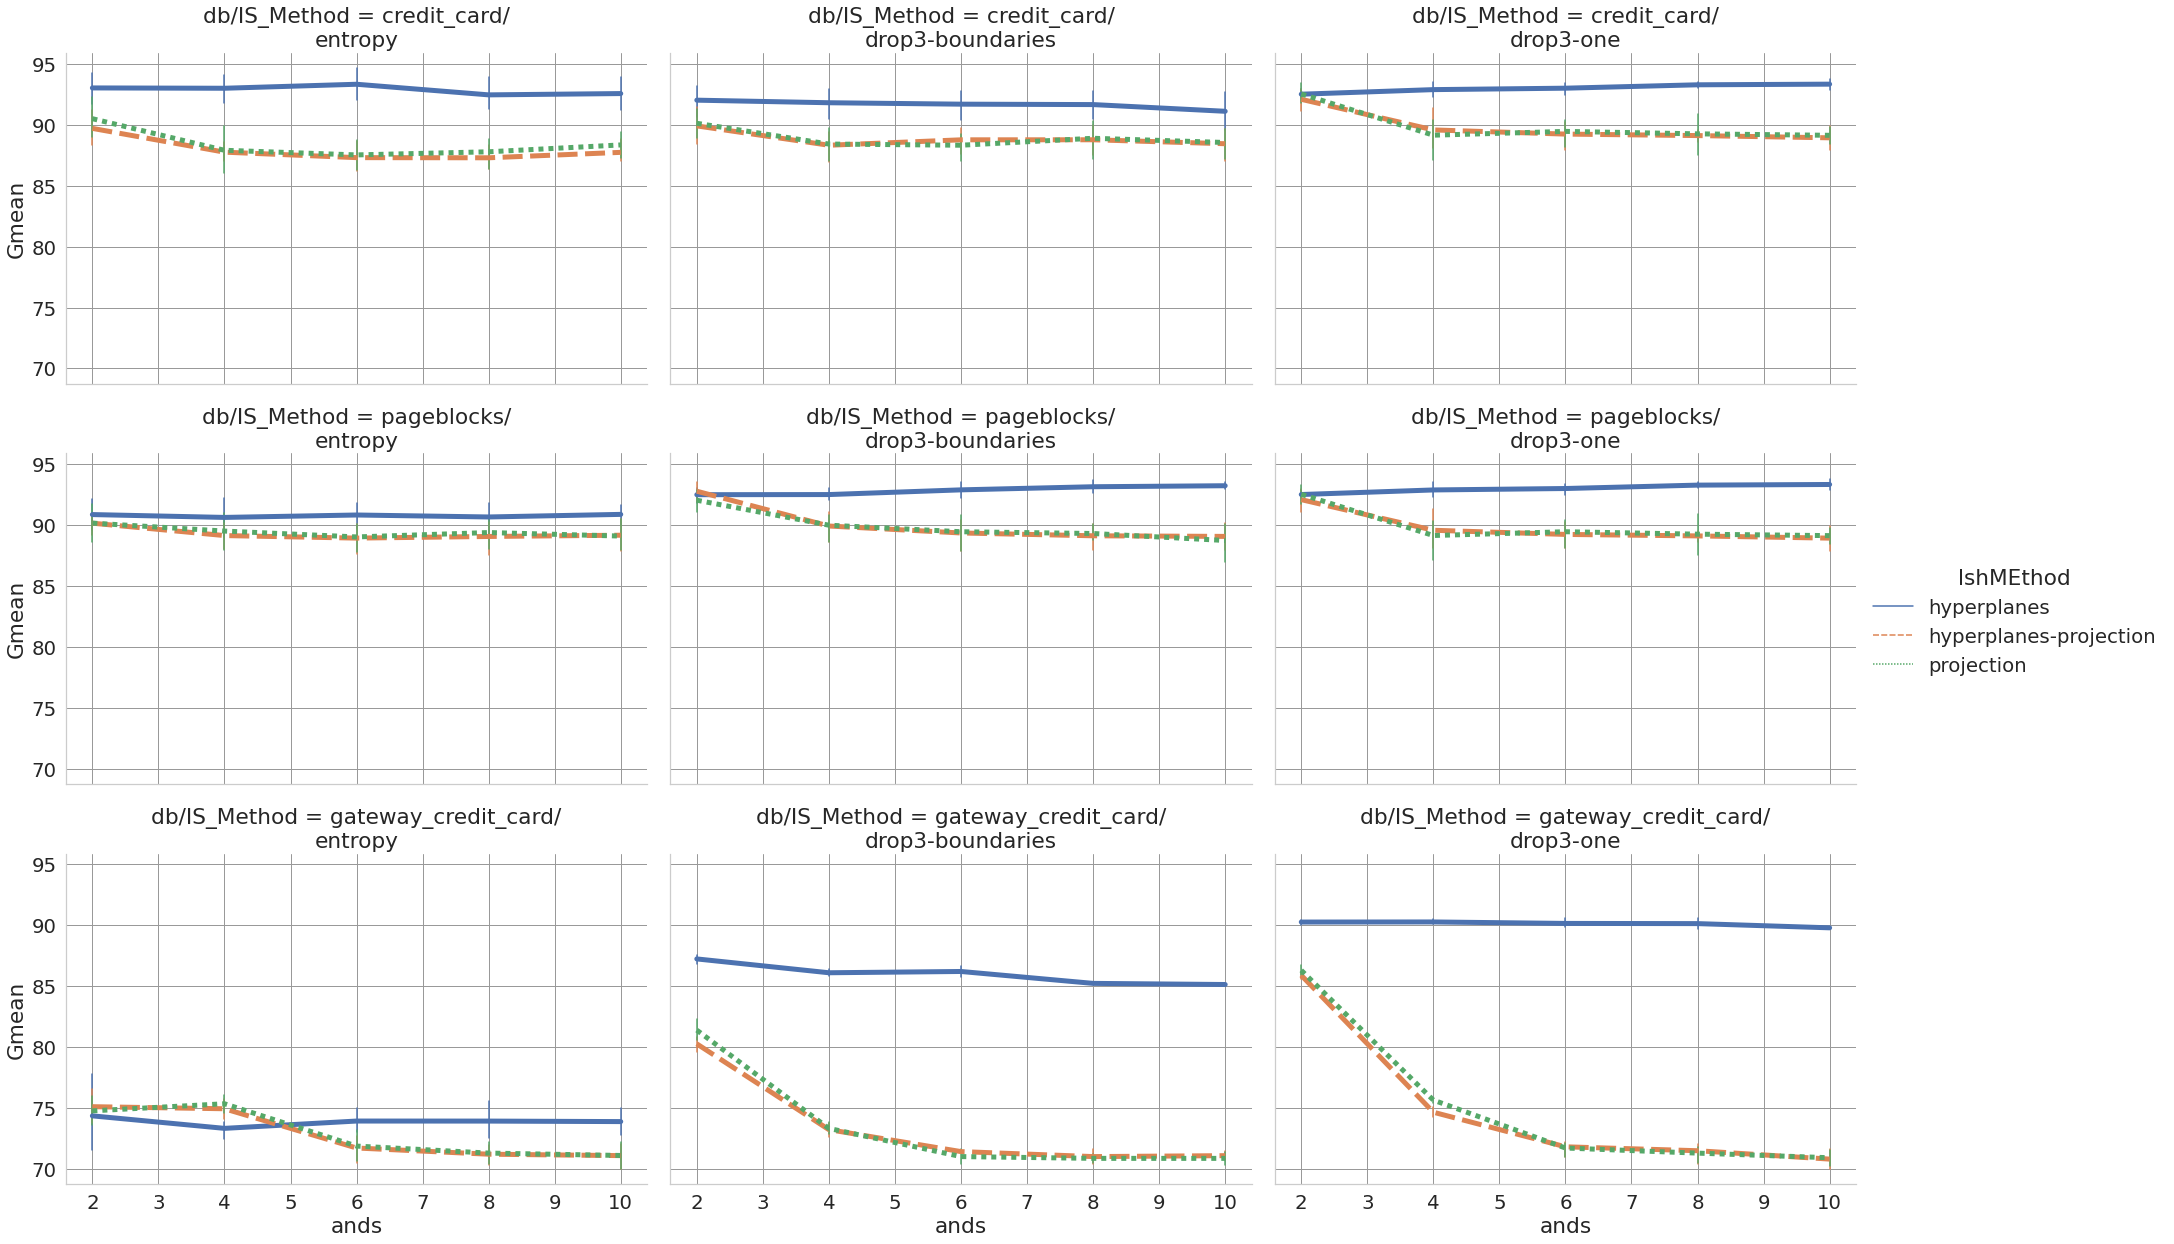

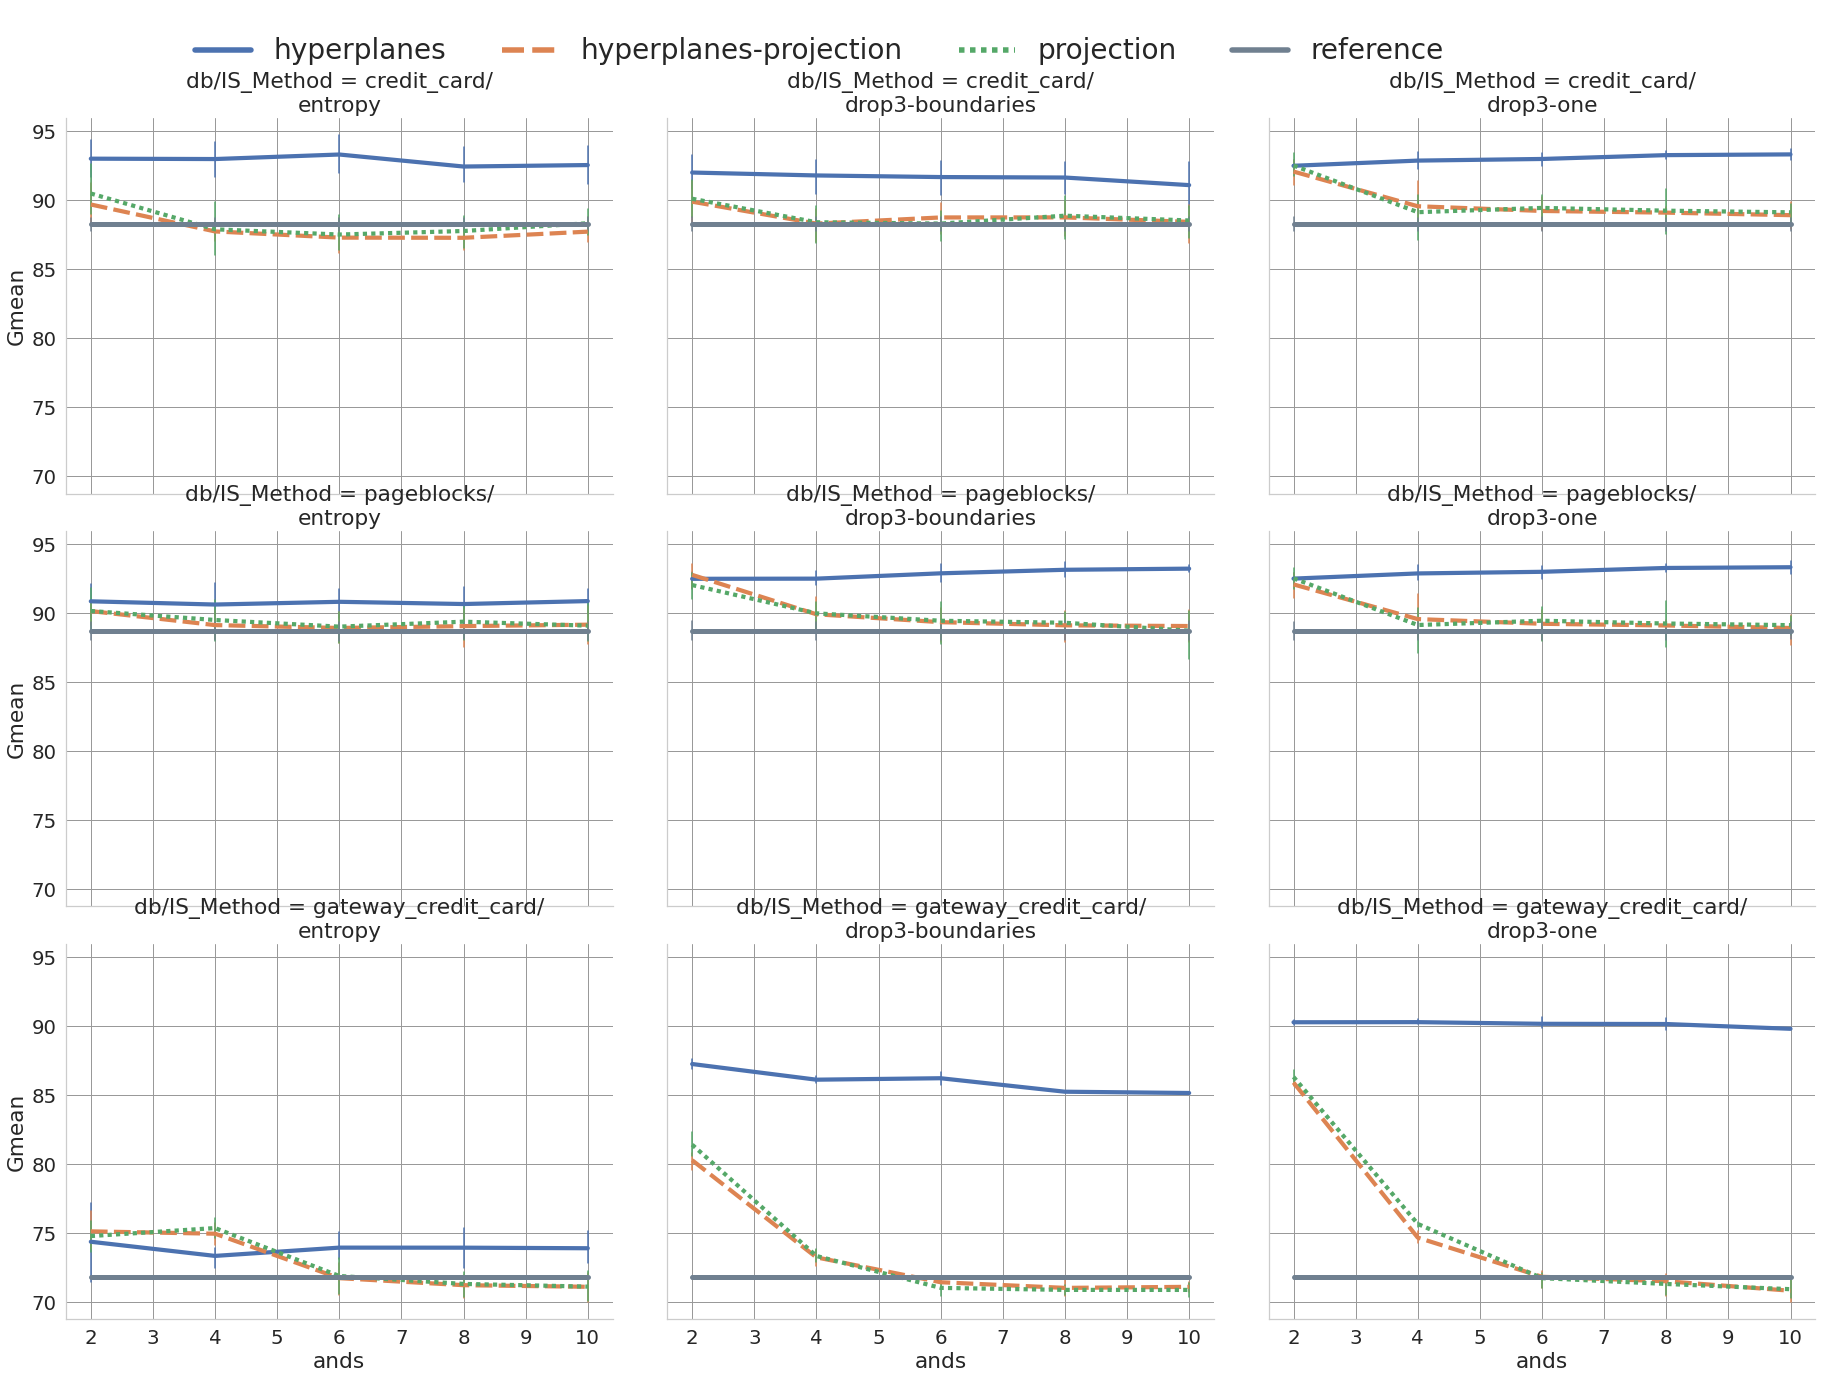

In [46]:
sns.set(font_scale=1.8, style='whitegrid',
        rc={'grid.color': '.6'})
g,_ = plot_9_results(df_toplot, best_no_is, measure= 'Gmean', measure_for_best='Gmean', aspect =1.5, height=5.8)

# Table Generation

In [ ]:
def to_mean_std_cell(df, cols_only_mean = ['model_complexity']):
    columns = list(df.columns)
    table = pd.DataFrame()
    idx = 0
    for c in range(int(len(columns)/2)):
        if columns[c+idx][0] not in cols_only_mean:
            table[columns[c+idx][0]] = df[columns[c+idx] ].astype('str') + " +- " +  df[columns[c+idx+1]].astype('str')
        else:
            table[columns[c+idx][0]] = df[columns[c+idx] ].astype('str')
        idx+=1
    return(table)

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

In [ ]:
order_cols = ['sensibility', 'specificity', 'F1', 'Gmean', 'balancedAcc', 
              'mcc','Reduction of DataSet(%)', 'model_complexity']

cols_to_ignore = ['timeIS', 'timeLSH', 'Total Time', 
                  'level_6', 'imbalance', 'trees','depth',
                  'tp', 'tn', 'fp', 'fn', 'precision', 'accuracy',
                  'wtdAcc', 'AreaROC', 'precision']

In [ ]:
results_dedup = drop3_entropy.drop_duplicates(cols_to_dedup +[ 'one_class_method'])
cond= results_dedup.imbalance == True

In [ ]:
to_table = (results_dedup[cond].groupby(factorsIS)
                .apply(lambda g : ut.get_best_for(g, measures, measure_sort = 'Gmean', factorsModel = factorsModel))
                .reset_index())
to_table = to_table[to_table.type=='test'].drop(cols_to_ignore, axis = 1)
to_table['isMethod'] = to_table['isMethod'] + "-" + to_table['one_class_method'] 
to_table= to_table.groupby(['database','lshMEthod', 'isMethod', 'ands']).agg(['mean', 'std']).round(2)
table = to_mean_std_cell(to_table)[order_cols]

In [ ]:
factorsNOIS = ['database','lshMEthod', 'isMethod', 'ands',]
best_no_is_table = best_no_is.copy()
best_no_is_table['lshMEthod'] = 'NoIS'
best_no_is_table['isMethod'] = 'NoIS'
best_no_is_table['ands'] = 'NoIS'
table_reference =( best_no_is_table[best_no_is_table.type == 'test']
                  .drop(cols_to_ignore + ['level_1', 'k'], axis = 1, errors='ignore')
                  .groupby(factorsNOIS)
                  .agg(['mean', 'std'])
                  .round(2))
table_reference = to_mean_std_cell(table_reference)

In [ ]:
def get_final_table(reference, is_table, db):
    db_table = pd.concat([reference.loc[[i for i in reference.index if db in i], :], 
                          is_table.loc[[i for i in is_table.index if db in i], :]])
    return(db_table.fillna("--"))

db = results_dedup.database.unique()
with pd.ExcelWriter('table.xlsx') as writer:
    get_final_table(table_reference, table, db[0]).style.apply(highlight_max, axis = 0).to_excel(writer, sheet_name=db[0])
    get_final_table(table_reference, table, db[1]).style.apply(highlight_max, axis = 0).to_excel(writer, sheet_name=db[1])
    get_final_table(table_reference, table, db[2]).style.apply(highlight_max, axis = 0).to_excel(writer, sheet_name=db[2])

# Hypothesis Testing

First we will use Kruskal-Wallis H Test to detemrine if there is evidence that we have real differences among the methods:
1. separate the groups in LSH for all datasets and reference for all datasets
2. test if there is difference

In [ ]:
from scipy.stats import kruskal
from scipy.stats import friedmanchisquare

def kruskal_test (data_list):
    
    stat, p = kruskal(*data_list)
    print('Statistics=%.6f, p=%.6f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')
    return (stat,p)


def friedman_test (data_list, limit = None):
    to_test = data_list if limit is None else [c[0:limit] for c in data_list]
    stat, p = friedmanchisquare(*to_test)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')
    return (stat,p)
    
    


In [ ]:
kruskal_test([best_no_is.loc[best_no_is.type=='test', 'Gmean'], df_toplot.loc[df_toplot.type=='test', 'Gmean']])

Now we will asses if there is difference among the methods and their configurations and see the rankings

In [ ]:
import itertools
metric= 'Gmean'
ismet = df_toplot.one_class_method.unique()
lsh = df_toplot.lshMEthod.unique()
ands = df_toplot.ands.unique()

In [ ]:
def friedman_test(*args):
    """
        Performs a Friedman ranking test.
        Tests the hypothesis that in a set of k dependent samples groups (where k >= 2) at least two of the groups represent populations with different median values.
        
        Parameters
        ----------
        sample1, sample2, ... : array_like
            The sample measurements for each group.
            
        Returns
        -------
        F-value : float
            The computed F-value of the test.
        p-value : float
            The associated p-value from the F-distribution.
        rankings : array_like
            The ranking for each group.
        pivots : array_like
            The pivotal quantities for each group.
            
        References
        ----------
        M. Friedman, The use of ranks to avoid the assumption of normality implicit in the analysis of variance, Journal of the American Statistical Association 32 (1937) 674–701.
        D.J. Sheskin, Handbook of parametric and nonparametric statistical procedures. crc Press, 2003, Test 25: The Friedman Two-Way Analysis of Variance by Ranks
    """
    k = len(args)
    if k < 2: raise ValueError('Less than 2 levels')
    n = len(args[0])
    if len(set([len(v) for v in args])) != 1: raise ValueError('Unequal number of samples')

    rankings = []
    for i in range(n):
        row = [col[i] for col in args]
        row_sort = sorted(row)
        rankings.append([row_sort.index(v) + 1 + (row_sort.count(v)-1)/2. for v in row])

    rankings_avg = [np.mean([case[j] for case in rankings]) for j in range(k)]
    rankings_cmp = [r/np.sqrt(k*(k+1)/(6.*n)) for r in rankings_avg]

    chi2 = ((12*n)/float((k*(k+1))))*((np.sum(r**2 for r in rankings_avg))-((k*(k+1)**2)/float(4)))
    iman_davenport = ((n-1)*chi2)/float((n*(k-1)-chi2))

    p_value = 1 - st.f.cdf(iman_davenport, k-1, (k-1)*(n-1))

    alpha = 0.05
    print(f"p={p_value:.6F}")

    if p_value > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

    return iman_davenport, p_value, rankings_avg, rankings_cmp

In [ ]:
combinations = list(itertools.product(ismet, lsh))
data_list = [df_toplot.loc[
    (df_toplot.one_class_method ==  is_lsh_and[0]) 
    & (df_toplot.lshMEthod ==  is_lsh_and[1]) 
    & (df_toplot.type=='test'), metric].values for is_lsh_and in combinations]

data_list_count = [len(c) for c in data_list]
min(data_list_count)

f, p, ranks, pivot = friedman_test(*[c[0:min(data_list_count)] for c in data_list])

ranks_df = pd.DataFrame(columns = ['is_method', "lsh", "rank"])
for i,c in enumerate(combinations):
    is_m, lsh_f = c
    ranks_df.loc[i, :] = [is_m, lsh_f,ranks[i]]
g = sns.catplot(data=ranks_df, hue = "is_method", y = 'lsh', x = 'rank', kind = 'bar', aspect = 2, orient = 'h')
g.ax.set_title("No ands")

In [ ]:
combinations = list(itertools.product(ismet, lsh, ands))
data_list = [df_toplot.loc[
    (df_toplot.one_class_method ==  is_lsh_and[0]) 
    & (df_toplot.lshMEthod ==  is_lsh_and[1])
    & (df_toplot.ands ==  is_lsh_and[2])
    & (df_toplot.type=='test'), metric].values for is_lsh_and in combinations]

data_list_count = [len(c) for c in data_list]
min(data_list_count)

f, p, ranks, pivot = friedman_test(*[c[0:min(data_list_count)] for c in data_list])

ranks_df = pd.DataFrame(columns = ['is_method', "lsh", "ands", "rank"])
for i,c in enumerate(combinations):
    is_m, lsh_f, a_f = c
    ranks_df.loc[i, :] = [is_m, lsh_f,a_f, ranks[i]]
g = sns.catplot(data=ranks_df, hue = "is_method", y = 'lsh', x = 'rank', kind = 'bar', aspect = 2, orient = 'h', col = 'ands')
g

In [41]:
from scipy.stats import wilcoxon
ref = best_no_is.drop_duplicates(["database", "k", "type"])
ref = ref.loc[(ref.type == 'test'), ['database', 'k', metric]].copy()

In [60]:
.

numpy.dtype

In [62]:
pairwise_comp = pd.DataFrame(columns = ['is_method', "lsh", "ands", "p", "conclusion", "statistic", "avg", "avg_ref","is_win"])
alpha = 0.05
for i,c in enumerate(combinations):
	is_m, lsh_f, a_f = c
	condition = ( (df_toplot.ands==4)
				& (df_toplot.one_class_method==is_m) 
				& (df_toplot.lshMEthod==lsh_f)
				& (df_toplot.type=="test") )

	first = df_toplot.loc[condition,   ['database', 'k', metric]].copy()
	#print ("shape is", first.shape)
	ref_adj = pd.merge(ref, first.drop(metric, axis = 1), on = ['database', 'k'])
	#print ("shape is", ref_adj.shape)
	stat, p = wilcoxon(ref_adj[metric], first[metric])
	avg_met = first[metric].mean()
	avg_ref = ref_adj[metric].mean()
	is_diff_dist = p <= alpha
	is_win = (avg_met>avg_ref )and (is_diff_dist)
	pairwise_comp.loc[i, :] = [is_m, lsh_f,a_f, p, is_diff_dist , stat, avg_met, avg_ref, is_win]

pairwise_comp= pairwise_comp.convert_dtypes()
pairwise_comp.dtypes

is_method      string
lsh            string
ands            Int64
p             float64
conclusion    boolean
statistic       Int64
avg           float64
avg_ref       float64
is_win        boolean
dtype: object

In [82]:
from statsmodels.stats.multitest import multipletests
conclusion_corr, p_corr, _, _ = multipletests(pairwise_comp.p, method = 'holm')
pairwise_comp['p_corr'] = p_corr
pairwise_comp['conclusion_corr'] = conclusion_corr
pairwise_comp['is_win_corr'] = (pairwise_comp['conclusion_corr']) &  (pairwise_comp['avg']>pairwise_comp['avg_ref'])

In [83]:
pairwise_comp.groupby(['is_method', "lsh"])['is_win'].sum()

is_method         lsh                   
drop3-boundaries  hyperplanes               5.0
                  hyperplanes-projection    0.0
                  projection                0.0
drop3-one         hyperplanes               5.0
                  hyperplanes-projection    5.0
                  projection                5.0
entropy           hyperplanes               5.0
                  hyperplanes-projection    0.0
                  projection                5.0
Name: is_win, dtype: float64

In [90]:
comp = pairwise_comp.groupby(['is_method', "lsh"]).agg({'is_win_corr': 'sum', 'avg_ref': 'mean', 'avg': 'mean'}).reset_index()

In [ ]:
itertools.permutations()

In [101]:
winners = comp.loc[comp.is_win_corr>=1.0, ["is_method", "lsh"]].values
winners  = list(itertools.combinations(winners, 2))

In [104]:
winners = comp.loc[comp.is_win_corr>=1.0, ["is_method", "lsh"]].values
winners  = list(itertools.combinations(winners, 2))
winners


[(array(['drop3-boundaries', 'hyperplanes'], dtype=object),
  array(['drop3-one', 'hyperplanes'], dtype=object)),
 (array(['drop3-boundaries', 'hyperplanes'], dtype=object),
  array(['entropy', 'hyperplanes'], dtype=object)),
 (array(['drop3-one', 'hyperplanes'], dtype=object),
  array(['entropy', 'hyperplanes'], dtype=object))]

In [122]:
pairwise_winners = pd.DataFrame(columns = ['method1', 'method2' , "ands", "p", "winner", "statistic", "avg_ref1", "avg_ref2"])
alpha = 0.05
i = 0

for is_met_comb in winners:
    print(is_met_comb)
    ref1_is, ref1_lsh = is_met_comb[0]
    ref2_is, ref2_lsh = is_met_comb[1]

    for a in ands:
        cond1 = ( (df_toplot.ands==a)
				& (df_toplot.one_class_method==ref1_is) 
				& (df_toplot.lshMEthod==ref1_lsh)
				& (df_toplot.type=="test") )
        
        ref1 = df_toplot.loc[cond1, [metric, 'database', 'k']].copy()

        cond2 = ( (df_toplot.ands==a)
				& (df_toplot.one_class_method==ref2_is) 
				& (df_toplot.lshMEthod==ref2_lsh)
				& (df_toplot.type=="test") )

        ref2 = df_toplot.loc[cond2, [metric, 'database', 'k']].copy()
        
        
        if ref1.shape[0] > ref2.shape[0]:
            print("adjust ref1")
            ref1 = pd.merge(ref1, ref2.drop(metric, axis = 1), on = ['database', 'k'])
        elif ref2.shape[0] > ref1.shape[0]:
            print("adjust ref2")
            ref2 = pd.merge(ref2, ref1.drop(metric, axis = 1), on = ['database', 'k'])
        else:
            print("no adjustment")
        
        print(ref2.shape, ref1.shape)

        stat, p = wilcoxon(ref1[metric], ref2[metric])
        avg_ref1 = ref1.mean()[0]
        avg_ref2 = ref2.mean()[0]
        is_diff_dist = p <= alpha
        met1 = f"{ref1_is}_{ref1_lsh}"
        met2 = f"{ref2_is}_{ref2_lsh}"
        win = "None"
        if (avg_ref1>avg_ref2 ) and ( p <= alpha):
            win = met1
        elif (avg_ref2>avg_ref1 ) and ( p <= alpha):
            win = met2
        else:
            win = "None"

        pairwise_winners.loc[i, :] = [met1,
                                      met2,
                                      a,
                                      p,
                                      win,
                                      stat,
                                      avg_ref1,
                                      avg_ref2]
        i = i+1

pairwise_winners= pairwise_winners.convert_dtypes()




(array(['drop3-boundaries', 'hyperplanes'], dtype=object), array(['drop3-one', 'hyperplanes'], dtype=object))
adjust ref2
(14, 3) (14, 3)
adjust ref2
(12, 3) (12, 3)
adjust ref2
(12, 3) (12, 3)
adjust ref2
(12, 3) (12, 3)
no adjustment
(12, 3) (12, 3)
(array(['drop3-boundaries', 'hyperplanes'], dtype=object), array(['entropy', 'hyperplanes'], dtype=object))
adjust ref2
(14, 3) (14, 3)
adjust ref2
(12, 3) (12, 3)
adjust ref2
(12, 3) (12, 3)
adjust ref2
(12, 3) (12, 3)
adjust ref2
(12, 3) (12, 3)
(array(['drop3-one', 'hyperplanes'], dtype=object), array(['entropy', 'hyperplanes'], dtype=object))
no adjustment
(15, 3) (15, 3)
adjust ref2
(14, 3) (14, 3)
adjust ref2
(13, 3) (13, 3)
adjust ref2
(13, 3) (13, 3)
adjust ref2
(12, 3) (12, 3)


In [123]:
pairwise_winners

,method1,method2,ands,p,winner,statistic,avg_ref1,avg_ref2
0,drop3-boundaries_hyperplanes,drop3-one_hyperplanes,2,0.067627,None,23,90.815737,91.891336
1,drop3-boundaries_hyperplanes,drop3-one_hyperplanes,4,0.002441,drop3-one_hyperplanes,3,91.192533,92.427348
2,drop3-boundaries_hyperplanes,drop3-one_hyperplanes,6,0.026855,drop3-one_hyperplanes,11,91.269062,92.545050
3,drop3-boundaries_hyperplanes,drop3-one_hyperplanes,8,0.016113,drop3-one_hyperplanes,9,91.198721,92.747775
4,drop3-boundaries_hyperplanes,drop3-one_hyperplanes,10,0.012207,drop3-one_hyperplanes,8,90.988574,92.733443
5,drop3-boundaries_hyperplanes,entropy_hyperplanes,2,0.057983,None,22,90.815737,86.774898
6,drop3-boundaries_hyperplanes,entropy_hyperplanes,4,0.380371,None,27,91.192533,88.591955
7,drop3-boundaries_hyperplanes,entropy_hyperplanes,6,0.339355,None,26,91.269062,88.894739
8,drop3-boundaries_hyperplanes,entropy_hyperplanes,8,0.092285,None,17,91.198721,88.856173
9,drop3-boundaries_hyperplanes,entropy_hyperplanes,10,0.176270,None,21,90.988574,88.838594
